### Imports

In [3]:
import pandas as pd
import os
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import scipy.stats as st
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import sys
import time

CURRENT_DIR = Path(os.getcwd())
# Move to the root directory
ROOT_DIR = CURRENT_DIR.parents[0]  # Adjust the number based on your folder structure

# Add the root directory to the system path
sys.path.append(str(ROOT_DIR))

# Import the importlib module
import importlib

# import function implementations
import stst_urls

# Reload the modules
importlib.reload(stst_urls)

# Re-import the functions
from stst_urls import GTX_URL

# Input Raw File and Decoder File

In [36]:
wafer_codes = [
    "QCHZZ",
]  # List of wafer codes

ANALYSIS_RUN_NAME = "debug"

DECODER_FILE = "QC WAFER_LAYOUT 24Dec.csv"
DECODER_FILE_PATH = ROOT_DIR / "decoders" / DECODER_FILE
RESULTS_FILE_PATH = ROOT_DIR / "results"

EXPORTS_FILEPATH = ROOT_DIR / "exports"
# Create the exports folder if it doesn't exist
if not os.path.exists(EXPORTS_FILEPATH):
    os.makedirs(EXPORTS_FILEPATH)

warnings.filterwarnings("ignore")


def liv_raw_filelink_finder(wafer_codes, fileserver_link: str, product_code="QC"):
    # Add the product code to the end of the fileserver link
    fileserver_link = f"{fileserver_link}{product_code}/"
    print(f"fileserver link: {fileserver_link}")

    # Fetch the directory listing
    response = requests.get(fileserver_link, verify=False)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all links in the directory listing
    links = soup.find_all("a")

    # Filter the links to find subdirectories that match the wafer codes
    subdirectory_urls = []
    for link in links:
        href = link.get("href")
        if href and any(wafer_code in href for wafer_code in wafer_codes):
            subdirectory_urls.append(fileserver_link + href)

    # Initialize lists for different types of files and a dictionary for machine names
    file_urls = []
    file_cod_urls = []
    file_degradation_urls = []
    machine_list = []
    machine_dict = {}

    # Iterate over wafer codes and subdirectory URLs simultaneously
    for wafer_code, subdirectory_url in zip(wafer_codes, subdirectory_urls):
        response = requests.get(subdirectory_url, verify=False)
        soup = BeautifulSoup(response.content, "html.parser")
        links = soup.find_all("a")

        latest_file = None
        latest_cod_file = None
        latest_degradation_file = None

        latest_time = ""
        latest_cod_time = ""
        latest_degradation_time = ""
        machine_name = None

        for link in links:
            href = link.get("href")
            if href and "RAW" in href:
                time_str = href[-18:-4]  # Extract the time string
                if not machine_name:
                    machine_name = href[:6]  # Extract the machine name (first 6 characters)

                if "COD250" in href:
                    if time_str > latest_cod_time:
                        latest_cod_time = time_str
                        latest_cod_file = subdirectory_url + href
                elif "COD70" in href:
                    if time_str > latest_degradation_time:
                        latest_degradation_time = time_str
                        latest_degradation_file = subdirectory_url + href
                else:
                    if time_str > latest_time:
                        latest_time = time_str
                        latest_file = subdirectory_url + href

        if latest_file:
            file_urls.append(latest_file)
        if latest_cod_file:
            file_cod_urls.append(latest_cod_file)
        if latest_degradation_file:
            file_degradation_urls.append(latest_degradation_file)
        if machine_name:
            machine_list.append(machine_name)
            machine_dict[wafer_code] = machine_name

    return file_urls, file_cod_urls, file_degradation_urls, machine_list, machine_dict


# Calling code
file_urls, file_cod_urls, file_degradation_urls, machine_list, machine_dict = liv_raw_filelink_finder(wafer_codes, GTX_URL, "QC")
print(file_urls)

# DEBUG: INPUT LINKS TO OTHER GTX FILES HERE
# file_urls = [
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_DNS-LIVTKCOD_LCRVCOD250-DNS_RAW20250227044906.CSV",
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250228082707.CSV",
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250311164324.CSV",
# ]
# print(file_urls)

fileserver link: https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/
['https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHZZ/LIV_54_QCHZZ_DNS-LIVTKCOD_LIVTK-DNS_RAW20250314032324.CSV']


# Transform Data to Desired Raw Sweep Format

- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file
- loops for every csv file chosen, and stores raw_sweep dataframes

In [34]:
def transform_raw_liv_file(file_url, decoder_file_path):
    start_time = time.time()

    # Step 1: Read the CSV file from the URL, skipping the first 19 rows
    print("Step 1: Reading the CSV file...")
    df = pd.read_csv(
        file_url,
        skiprows=19,
    )
    print(f"Step 1 completed in {time.time() - start_time:.2f} seconds")

    # Step 2: Read the CSV file again to extract the second row
    print("Step 2: Extracting the wafer ID...")
    header_df = pd.read_csv(file_url, nrows=2)
    wafer_id = header_df.iloc[1, 1]
    print(f"Wafer ID: {wafer_id}")
    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left")
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.2f} seconds")

    return df_raw_sweeps


def transform_raw_liv_file_first30rows(file_url, decoder_file_path):
    start_time_overall = time.time()

    # Step 1: Read the header to extract the wafer ID
    start_time = time.time()
    print("Step 1: Reading the header to extract the wafer ID...")

    header_df = pd.read_csv(file_url, nrows=2)
    wafer_id = header_df.iloc[1, 1]
    print(f"Wafer ID: {wafer_id}")
    print(f"Step 1 completed in {time.time() - start_time:.2f} seconds")

    # Step 2: Read the data rows, skipping the header rows
    print("Step 2: Reading the data rows, skipping the header rows...")
    df = pd.read_csv(file_url, skiprows=19, nrows=30)

    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    start_time = time.time()
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    start_time = time.time()
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    start_time = time.time()
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    start_time = time.time()
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    start_time = time.time()
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    start_time = time.time()
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    start_time = time.time()
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    start_time = time.time()
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left")
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    start_time = time.time()
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    start_time = time.time()
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    start_time = time.time()
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    start_time = time.time()
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time_overall
    print(f"Total time taken: {total_time:.2f} seconds")

    return (df_raw_sweeps, n_meas, n_devices)


raw_sweeps_tables = []
device_numbers = []

warnings.filterwarnings("ignore")

# CALLING THE CODE
for file_url in file_urls:
    df_raw_sweeps, n_meas, n_devices = transform_raw_liv_file_first30rows(file_url, DECODER_FILE_PATH)
    raw_sweeps_tables.append(df_raw_sweeps)
    device_numbers.append(n_devices)

# Display the first 10 rows of the raw_sweeps table
print(raw_sweeps_tables[0].head(10))
print(device_numbers[0])

Step 1: Reading the header to extract the wafer ID...
Wafer ID: QCHZZ
Step 1 completed in 4.43 seconds
Step 2: Reading the data rows, skipping the header rows...
Step 2 completed in 8.99 seconds
Step 3: Subsetting the data frame...
Step 3 completed in 0.01 seconds
Step 4: Transposing the data frame...
Step 4 completed in 0.01 seconds
Step 5: Splitting the transposed table...
Step 5 completed in 0.01 seconds
Step 6: Learning data dimensions...
Number of Current Measurements per Device: 63
Number of Devices: 30
Step 6 completed in 0.00 seconds
Step 7: Concatenating Voltage columns...
Step 7 completed in 0.01 seconds
Step 8: Concatenating PD columns...
Step 8 completed in 0.00 seconds
Step 9: Performing Cartesian join...
Step 9 completed in 0.00 seconds
Step 10: Adding device coordinates...
Step 10 completed in 0.00 seconds
Step 11: Merging with decoder file...
Step 11 completed in 1.06 seconds
Step 12: Renaming columns...
Step 12 completed in 0.00 seconds
Step 13: Adding current column..

# I_th Data processing

In [37]:
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def find_ith_value(intensity, current, window_length=5, polyorder=2):
    try:
        # Sort data by current to ensure proper processing
        sorted_indices = np.argsort(current)
        current = current[sorted_indices]
        intensity = intensity[sorted_indices]

        # Normalize intensity using min-max scaling
        min_intensity = np.min(intensity)
        max_intensity = np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Apply Savitzky-Golay smoothing to normalized intensity
        smoothed_intensity_norm = savgol_filter(intensity_norm, window_length=window_length, polyorder=polyorder)

        # Compute differentials on normalized & smoothed data
        smoothed_dI_dC_norm = np.gradient(smoothed_intensity_norm, current)
        smoothed_d2I_dC2_norm = np.gradient(smoothed_dI_dC_norm, current)

        # Fit Gaussian to the smoothed second differential
        p0 = [np.max(smoothed_d2I_dC2_norm), np.median(current), np.std(current)]
        popt, pcov = curve_fit(gaussian, current, smoothed_d2I_dC2_norm, p0=p0)
        median_x = popt[1]  # Extract median x from Gaussian fit

        # Check for high error in Gaussian fit
        if np.any(np.diag(pcov) > 1):  # Adjust threshold as needed
            print("Warning: Abnormal LI curve detected due to high error in Gaussian fit.")
            return None

        if not np.isnan(median_x):
            # Split data at median_x
            left_side = current[current <= median_x]
            right_side = current[current > median_x]
            intensity_norm_left = intensity_norm[current <= median_x]
            intensity_norm_right = intensity_norm[current > median_x]

            # Check if either side is empty
            if len(left_side) == 0 or len(right_side) == 0:
                print("Warning: No reasonable I_th detected within bounds.")
                return None

            # Fit linear regression to both segments
            slope_left, intercept_left, _, _, _ = linregress(left_side, intensity_norm_left)
            slope_right, intercept_right, _, _, _ = linregress(right_side, intensity_norm_right)

            # Compute intersection point
            intersection_x = (intercept_right - intercept_left) / (slope_left - slope_right)
            ith_value = intersection_x  # No rounding

            return ith_value
        else:
            print("Warning: Gaussian fit failed, unable to determine ITH value.")
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None


def raw_sweep_ITH_evaluations(df_raw_sweeps, touchdown_number):
    # Calculate dV/dI
    df_raw_sweeps["dV/dI"] = (df_raw_sweeps["Vf"].diff()) / (df_raw_sweeps["LDI_mA"].diff())
    # Calculate dP/dI
    df_raw_sweeps["dP/dI"] = (df_raw_sweeps["PD"].diff()) / (df_raw_sweeps["LDI_mA"].diff())

    # Calculate second differentials
    df_raw_sweeps["d2V/dI2"] = df_raw_sweeps["dV/dI"].diff() / (df_raw_sweeps["LDI_mA"].diff())
    df_raw_sweeps["d2P/dI2"] = df_raw_sweeps["dP/dI"].diff() / (df_raw_sweeps["LDI_mA"].diff())

    # Initialize the ITH column
    df_raw_sweeps["ITH"] = np.nan

    # Iterate over each touchdown
    for touchdown in range(1, touchdown_number + 1):
        specific_data = df_raw_sweeps[df_raw_sweeps["TOUCHDOWN"] == touchdown]
        if not specific_data.empty:
            PD = specific_data["PD"].values
            LDI = specific_data["LDI_mA"].values
            ith_value = find_ith_value(PD, LDI)
            if ith_value is not None:
                df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"] == touchdown, "ITH"] = ith_value
            if ith_value is None:
                print(f"^^^ Above error in touchdown {touchdown}")

    return df_raw_sweeps



annotated_sweeps_tables = []


device_summary_tables = []


wafer_summary_tables = []



for df_raw_sweeps, num_devices in zip(raw_sweeps_tables, device_numbers):

    wafer_code = df_raw_sweeps["WAFER_ID"].iloc[0]

    annotated_sweeps = raw_sweep_ITH_evaluations(df_raw_sweeps, num_devices)

    annotated_sweeps_tables.append(annotated_sweeps)

    df_raw_sweeps.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_raw_sweeps.csv", index=False)

print(annotated_sweeps_tables[0].head(150))

^^^ Above error in touchdown 2
^^^ Above error in touchdown 3
^^^ Above error in touchdown 10
^^^ Above error in touchdown 13
^^^ Above error in touchdown 14
^^^ Above error in touchdown 15
^^^ Above error in touchdown 16
^^^ Above error in touchdown 21
^^^ Above error in touchdown 29
    WAFER_ID        Vf  TOUCHDOWN        PD   X_UM   Y_UM TE_LABEL      TYPE  \
0      QCHZZ  4.698077          1  0.017713 -43119 -60416    63N07  BL LASER   
1      QCHZZ  5.057280          1  0.019356 -43119 -60416    63N07  BL LASER   
2      QCHZZ  5.059837          1  0.022642 -43119 -60416    63N07  BL LASER   
3      QCHZZ  5.058840          1  0.022642 -43119 -60416    63N07  BL LASER   
4      QCHZZ  5.057843          1  0.020999 -43119 -60416    63N07  BL LASER   
..       ...       ...        ...       ...    ...    ...      ...       ...   
145    QCHZZ  5.037862          3  0.017713 -43119 -60116    63N0D  BL LASER   
146    QCHZZ  5.036750          3  0.019356 -43119 -60116    63N0D  BL LAS

# Raw Sweep Plotting

ValueError: Inputs must not be empty.

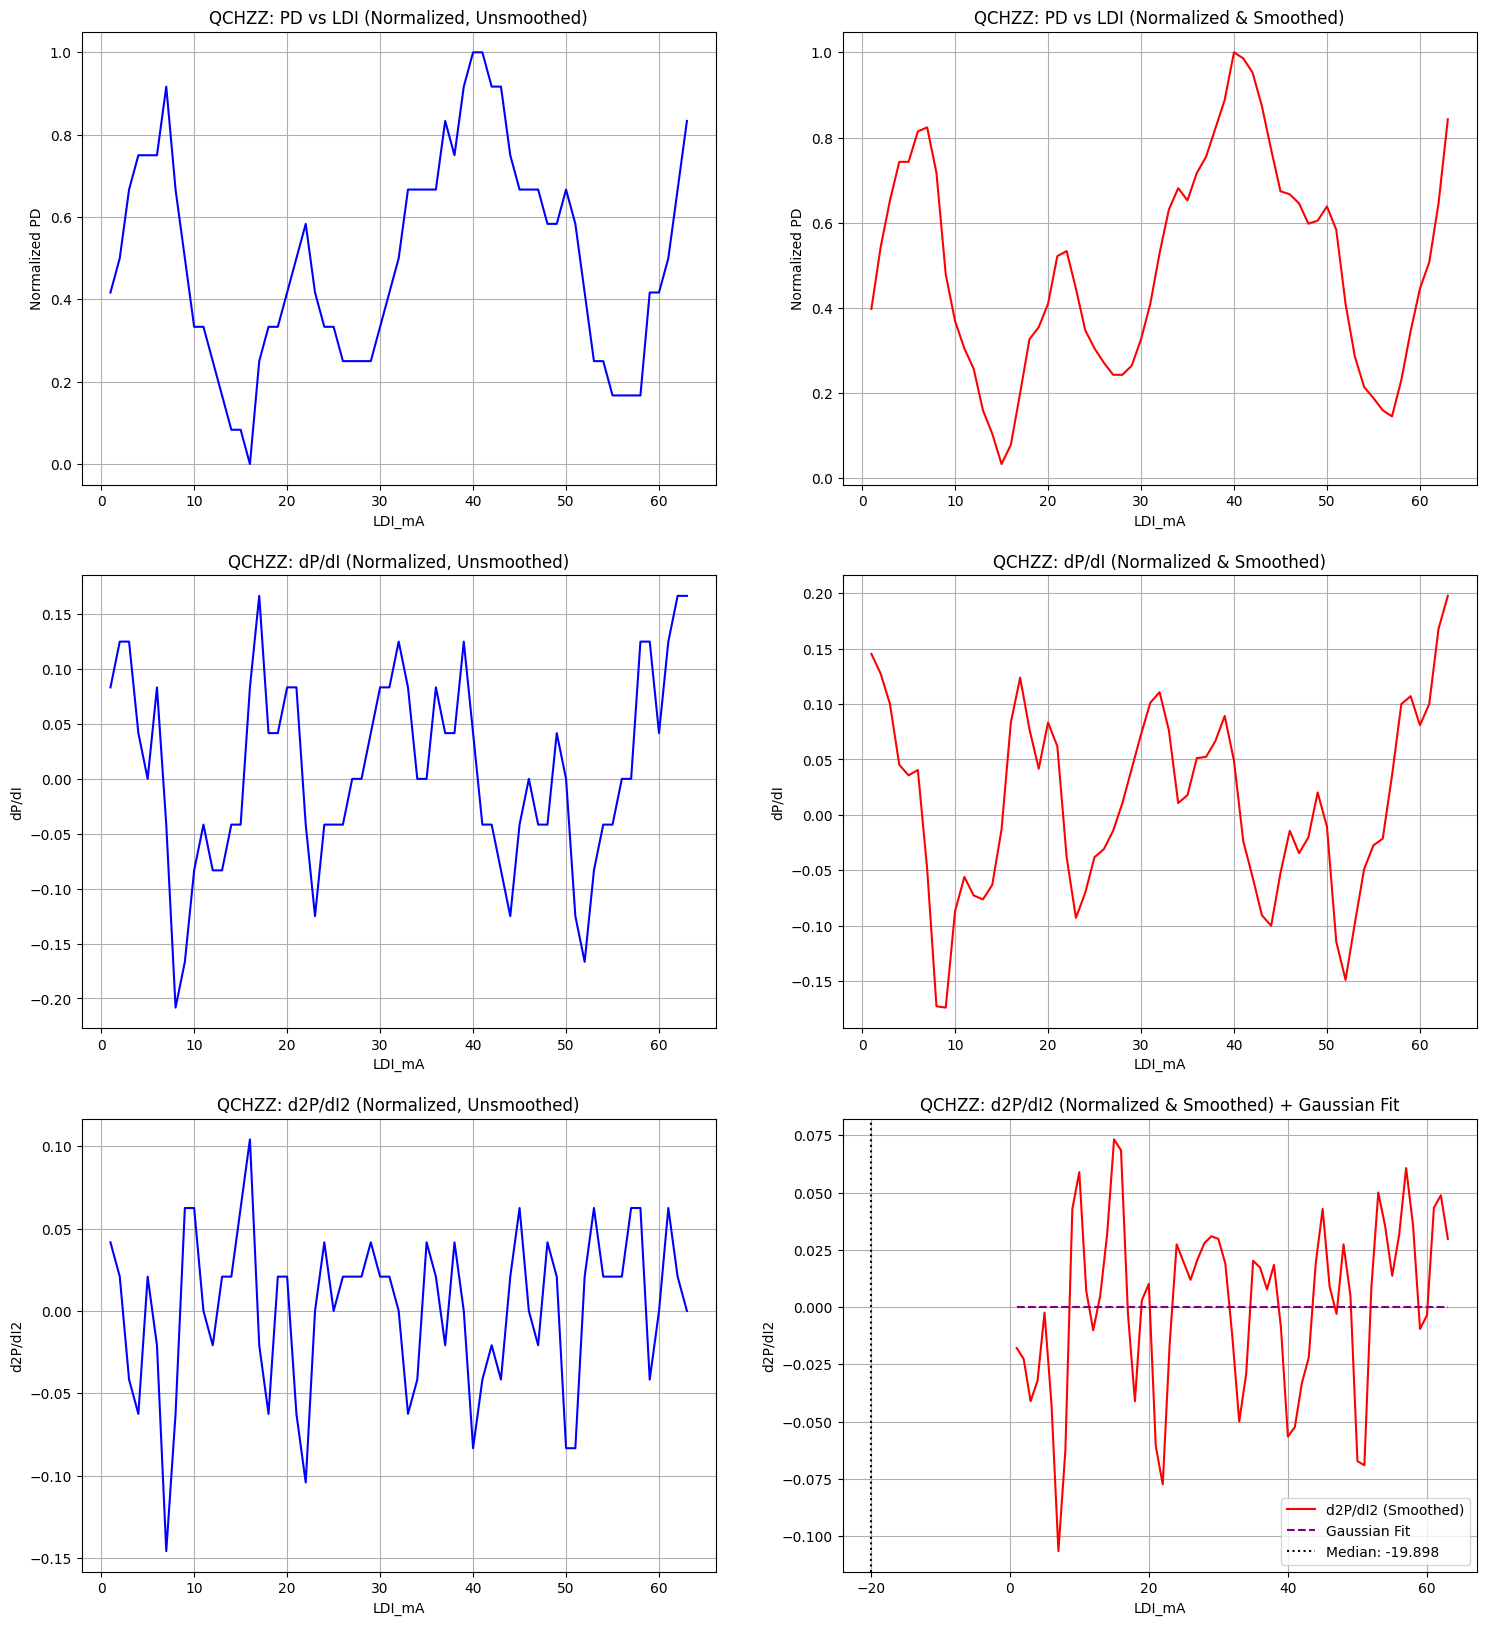

In [25]:
# Function to plot PD/LDI and Vf/LDI for a specific laser and wafer
def plot_specific_touchdown(df_raw_sweeps, wafer_code, touchdown, pnt_size):
    specific_data = df_raw_sweeps[(df_raw_sweeps["WAFER_ID"] == wafer_code) & (df_raw_sweeps["TOUCHDOWN"] == touchdown)]

    if specific_data.empty:
        print(f"No data found for Wafer Code: {wafer_code} and TOUCHDOWN: {touchdown}")
        return

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 15))

    # Plot PD/LDI
    ax1.scatter(specific_data["LDI_mA"], specific_data["PD"], s=pnt_size, color="blue")
    ax1.set_title(f"{wafer_code}: Scatter Plot of PD vs LDI_mA for TOUCHDOWN {touchdown}")
    ax1.set_xlabel("LDI_mA")
    ax1.set_ylabel("PD")
    ax1.grid(True)

    # Plot dP/dI
    ax3.scatter(specific_data["LDI_mA"], specific_data["dP/dI"], s=pnt_size, color="blue")
    ax3.set_title(f"{wafer_code}: Scatter Plot of dP/dI for TOUCHDOWN {touchdown}")
    ax3.set_xlabel("LDI_mA")
    ax3.set_ylabel("dP/dI")
    ax3.grid(True)

    # Plot d2P/dI2
    ax5.scatter(specific_data["LDI_mA"], specific_data["d2P/dI2"], s=pnt_size, color="blue")
    ax5.set_title(f"{wafer_code}: Scatter Plot of d2P/dI2 for TOUCHDOWN {touchdown}")
    ax5.set_xlabel("LDI_mA")
    ax5.set_ylabel("d2P/dI2")
    ax5.grid(True)

    # Plot Vf/LDI
    ax2.scatter(specific_data["LDI_mA"], specific_data["Vf"], s=pnt_size, color="green")
    ax2.set_title(f"{wafer_code}: Scatter Plot of Vf vs LDI_mA for TOUCHDOWN {touchdown}")
    ax2.set_xlabel("LDI_mA")
    ax2.set_ylabel("Vf")
    ax2.grid(True)

    # Plot dV/dI
    ax4.scatter(specific_data["LDI_mA"], specific_data["dV/dI"], s=pnt_size, color="green")
    ax4.set_title(f"{wafer_code}: Scatter Plot of dV/dI vs LDI_mA for TOUCHDOWN {touchdown}")
    ax4.set_xlabel("LDI_mA")
    ax4.set_ylabel("dV/dI")
    ax4.grid(True)

    # Plot d2V/dI2
    ax6.scatter(specific_data["LDI_mA"], specific_data["d2V/dI2"], s=pnt_size, color="green")
    ax6.set_title(f"{wafer_code}: Scatter Plot of d2V/dI2 vs LDI_mA for TOUCHDOWN {touchdown}")
    ax6.set_xlabel("LDI_mA")
    ax6.set_ylabel("d2V/dI2")
    ax6.grid(True)

    plt.tight_layout()

    plt.show()


def gaussian(x, a, mu, sigma):
    """Gaussian function for curve fitting."""
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


def plot_with_smoothing_and_normalization(df_raw_sweeps, wafer_code, touchdown, window_length=5, polyorder=2):
    specific_data = df_raw_sweeps[(df_raw_sweeps["WAFER_ID"] == wafer_code) & (df_raw_sweeps["TOUCHDOWN"] == touchdown)]

    if specific_data.empty:
        print(f"No data found for Wafer Code: {wafer_code} and TOUCHDOWN: {touchdown}")
        return

    # Sort data by LDI to ensure proper plotting
    specific_data = specific_data.sort_values(by="LDI_mA")

    # Normalize PD using min-max scaling
    min_PD = specific_data["PD"].min()
    max_PD = specific_data["PD"].max()
    specific_data["PD_norm"] = (specific_data["PD"] - min_PD) / (max_PD - min_PD)

    # Apply Savitzky-Golay smoothing to normalized PD
    smoothed_PD_norm = savgol_filter(specific_data["PD_norm"], window_length=window_length, polyorder=polyorder)

    # Compute differentials on normalized & smoothed data
    dP_dI_norm = np.gradient(specific_data["PD_norm"], specific_data["LDI_mA"])
    smoothed_dP_dI_norm = np.gradient(smoothed_PD_norm, specific_data["LDI_mA"])

    d2P_dI2_norm = np.gradient(dP_dI_norm, specific_data["LDI_mA"])
    smoothed_d2P_dI2_norm = np.gradient(smoothed_dP_dI_norm, specific_data["LDI_mA"])

    # Fit Gaussian to the smoothed second differential
    try:
        p0 = [np.max(smoothed_d2P_dI2_norm), np.median(specific_data["LDI_mA"]), np.std(specific_data["LDI_mA"])]
        popt, _ = curve_fit(gaussian, specific_data["LDI_mA"], smoothed_d2P_dI2_norm, p0=p0)
        gaussian_fit = gaussian(specific_data["LDI_mA"], *popt)
        median_x = popt[1]  # Extract median x from Gaussian fit
    except:
        gaussian_fit = np.zeros_like(smoothed_d2P_dI2_norm)
        median_x = np.nan  # Handle fit failure gracefully

    fig, axes = plt.subplots(3, 2, figsize=(18, 20))  # Extra row for line fitting plot

    # Normalized PD vs LDI (Unsmoothed)
    axes[0, 0].plot(specific_data["LDI_mA"], specific_data["PD_norm"], color="blue", label="Normalized PD (Raw)")
    axes[0, 0].set_title(f"{wafer_code}: PD vs LDI (Normalized, Unsmoothed)")
    axes[0, 0].set_xlabel("LDI_mA")
    axes[0, 0].set_ylabel("Normalized PD")
    axes[0, 0].grid(True)

    # Normalized PD vs LDI (Smoothed)
    axes[0, 1].plot(specific_data["LDI_mA"], smoothed_PD_norm, color="red", label="Normalized PD (Smoothed)")
    axes[0, 1].set_title(f"{wafer_code}: PD vs LDI (Normalized & Smoothed)")
    axes[0, 1].set_xlabel("LDI_mA")
    axes[0, 1].set_ylabel("Normalized PD")
    axes[0, 1].grid(True)

    # Normalized dP/dI (Unsmoothed)
    axes[1, 0].plot(specific_data["LDI_mA"], dP_dI_norm, color="blue", label="dP/dI (Raw)")
    axes[1, 0].set_title(f"{wafer_code}: dP/dI (Normalized, Unsmoothed)")
    axes[1, 0].set_xlabel("LDI_mA")
    axes[1, 0].set_ylabel("dP/dI")
    axes[1, 0].grid(True)

    # Normalized dP/dI (Smoothed)
    axes[1, 1].plot(specific_data["LDI_mA"], smoothed_dP_dI_norm, color="red", label="dP/dI (Smoothed)")
    axes[1, 1].set_title(f"{wafer_code}: dP/dI (Normalized & Smoothed)")
    axes[1, 1].set_xlabel("LDI_mA")
    axes[1, 1].set_ylabel("dP/dI")
    axes[1, 1].grid(True)

    # Normalized d2P/dI2 (Unsmoothed)
    axes[2, 0].plot(specific_data["LDI_mA"], d2P_dI2_norm, color="blue", label="d2P/dI2 (Raw)")
    axes[2, 0].set_title(f"{wafer_code}: d2P/dI2 (Normalized, Unsmoothed)")
    axes[2, 0].set_xlabel("LDI_mA")
    axes[2, 0].set_ylabel("d2P/dI2")
    axes[2, 0].grid(True)

    # Normalized d2P/dI2 (Smoothed) + Gaussian Fit
    axes[2, 1].plot(specific_data["LDI_mA"], smoothed_d2P_dI2_norm, color="red", label="d2P/dI2 (Smoothed)")
    axes[2, 1].plot(specific_data["LDI_mA"], gaussian_fit, color="purple", linestyle="dashed", label="Gaussian Fit")

    # Mark median_x with a vertical line
    if not np.isnan(median_x):
        axes[2, 1].axvline(median_x, color="black", linestyle="dotted", label=f"Median: {median_x:.3f}")

    axes[2, 1].set_title(f"{wafer_code}: d2P/dI2 (Normalized & Smoothed) + Gaussian Fit")
    axes[2, 1].set_xlabel("LDI_mA")
    axes[2, 1].set_ylabel("d2P/dI2")
    axes[2, 1].grid(True)
    axes[2, 1].legend()

    # ------------------- LINEAR FITTING SECTION (Separate Figure) -------------------
    if not np.isnan(median_x):
        # Split data at median_x
        left_side = specific_data[specific_data["LDI_mA"] <= median_x]
        right_side = specific_data[specific_data["LDI_mA"] > median_x]

        # Fit linear regression to both segments
        slope_left, intercept_left, _, _, _ = linregress(left_side["LDI_mA"], left_side["PD_norm"])
        slope_right, intercept_right, _, _, _ = linregress(right_side["LDI_mA"], right_side["PD_norm"])

        # Generate fitted lines
        fit_left = slope_left * left_side["LDI_mA"] + intercept_left
        fit_right = slope_right * right_side["LDI_mA"] + intercept_right

        # Compute intersection point
        intersection_x = (intercept_right - intercept_left) / (slope_left - slope_right)
        intersection_y = slope_left * intersection_x + intercept_left

        # Create a separate figure for linear fits
        plt.figure(figsize=(10, 6))

        # Plot original normalized PD data as scatter points
        plt.scatter(specific_data["LDI_mA"], specific_data["PD_norm"], color="green", marker="+", alpha=1, label="Original Data")

        # Plot linear fits
        plt.plot(left_side["LDI_mA"], fit_left, color="blue", label=f"Left Fit (Slope={slope_left:.3f})")
        plt.plot(right_side["LDI_mA"], fit_right, color="red", label=f"Right Fit (Slope={slope_right:.3f})")

        # Mark the intersection point
        plt.scatter(intersection_x, intersection_y, color="black", marker="x", s=200, label=f"Intersection at LDI={intersection_x:.3f}")

        # Labels and title
        plt.title(f"{wafer_code}: Linear Fits Split at Median")
        plt.xlabel("LDI_mA")
        plt.ylabel("Normalized PD")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def find_ith_value(df_raw_sweeps, wafer_code, touchdown, window_length=5, polyorder=2):
    specific_data = df_raw_sweeps[(df_raw_sweeps["WAFER_ID"] == wafer_code) & (df_raw_sweeps["TOUCHDOWN"] == touchdown)]

    if specific_data.empty:
        print(f"No data found for Wafer Code: {wafer_code} and TOUCHDOWN: {touchdown}")
        return None

    # Sort data by LDI to ensure proper processing
    specific_data = specific_data.sort_values(by="LDI_mA")

    # Normalize PD using min-max scaling
    min_PD = specific_data["PD"].min()
    max_PD = specific_data["PD"].max()
    specific_data["PD_norm"] = (specific_data["PD"] - min_PD) / (max_PD - min_PD)

    # Apply Savitzky-Golay smoothing to normalized PD
    smoothed_PD_norm = savgol_filter(specific_data["PD_norm"], window_length=window_length, polyorder=polyorder)

    # Compute differentials on normalized & smoothed data
    smoothed_dP_dI_norm = np.gradient(smoothed_PD_norm, specific_data["LDI_mA"])
    smoothed_d2P_dI2_norm = np.gradient(smoothed_dP_dI_norm, specific_data["LDI_mA"])

    # Fit Gaussian to the smoothed second differential
    try:
        p0 = [np.max(smoothed_d2P_dI2_norm), np.median(specific_data["LDI_mA"]), np.std(specific_data["LDI_mA"])]
        popt, _ = curve_fit(gaussian, specific_data["LDI_mA"], smoothed_d2P_dI2_norm, p0=p0)
        median_x = popt[1]  # Extract median x from Gaussian fit
    except:
        median_x = np.nan  # Handle fit failure gracefully

    if not np.isnan(median_x):
        # Split data at median_x
        left_side = specific_data[specific_data["LDI_mA"] <= median_x]
        right_side = specific_data[specific_data["LDI_mA"] > median_x]

        # Fit linear regression to both segments
        slope_left, intercept_left, _, _, _ = linregress(left_side["LDI_mA"], left_side["PD_norm"])
        slope_right, intercept_right, _, _, _ = linregress(right_side["LDI_mA"], right_side["PD_norm"])

        # Compute intersection point
        intersection_x = (intercept_right - intercept_left) / (slope_left - slope_right)
        ith_value = intersection_x

        return ith_value
    else:
        print("Gaussian fit failed, unable to determine ITH value.")
        return None


# INPUT THE DESIRED PROFILE TO EXAMINE HERE
# Define the specific wafer code and TOUCHDOWN number
WAFER_CODE = "QCHZZ"
TOUCHDOWN = 3

# Find the correct dataframe where the wafer code matches the input
df_raw_sweeps = None
for df in annotated_sweeps_tables:
    if df["WAFER_ID"].iloc[0] == WAFER_CODE:
        df_raw_sweeps = df
        break

if df_raw_sweeps is not None:
    # Plot for the specified touchdown number
    # plot_specific_touchdown(df_raw_sweeps, WAFER_CODE, TOUCHDOWN, pnt_size=5)
    plot_with_smoothing_and_normalization(df_raw_sweeps, WAFER_CODE, TOUCHDOWN, window_length=5, polyorder=2)
    ITH_value = find_ith_value(df_raw_sweeps, "QCHZZ", TOUCHDOWN)
    print(f"ITH value: {ITH_value}")
else:
    print(f"No data found for Wafer Code: {WAFER_CODE}")